In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
print("numpy_version:", np.__version__)
print("pandas_version:", pd.__version__)
#print("matPlotlib_version:", plt.__version__)
print("seaborn_version:", sns.__version__)
print("missingno_version:", msno.__version__)
#print("warning_version:", warning.__version__)


numpy_version: 1.21.6
pandas_version: 1.3.5
seaborn_version: 0.11.2
missingno_version: 0.4.2


In [3]:
DATA_PATH = "/kaggle/input/titanic/"
df_train = pd.read_csv(DATA_PATH + ("train.csv"))
df_test = pd.read_csv(DATA_PATH + ("test.csv"))
df_train.shape, df_test.shape
plt.style.use('seaborn')
sns.set(font_scale=2.5)
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 데이터 불러오기

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 결측치 확인하기

In [6]:
for col in df_train.columns:
    msg = 'column:{:>10}/t Percent of NaN value:{:.2f}%'.format(col,100*(df_train[col].isnull().sum()/df_train[col].shape[0]))
    print(msg)
    

column:PassengerId/t Percent of NaN value:0.00%
column:  Survived/t Percent of NaN value:0.00%
column:    Pclass/t Percent of NaN value:0.00%
column:      Name/t Percent of NaN value:0.00%
column:       Sex/t Percent of NaN value:0.00%
column:       Age/t Percent of NaN value:19.87%
column:     SibSp/t Percent of NaN value:0.00%
column:     Parch/t Percent of NaN value:0.00%
column:    Ticket/t Percent of NaN value:0.00%
column:      Fare/t Percent of NaN value:0.00%
column:     Cabin/t Percent of NaN value:77.10%
column:  Embarked/t Percent of NaN value:0.22%


In [7]:
for col in df_test.columns:
    msg = 'column:{:>10}/t Percent of NaN value:{:.2f}%'.format(col,100*(df_test[col].isnull().sum()/df_train[col].shape[0]))
    print(msg)

column:PassengerId/t Percent of NaN value:0.00%
column:    Pclass/t Percent of NaN value:0.00%
column:      Name/t Percent of NaN value:0.00%
column:       Sex/t Percent of NaN value:0.00%
column:       Age/t Percent of NaN value:9.65%
column:     SibSp/t Percent of NaN value:0.00%
column:     Parch/t Percent of NaN value:0.00%
column:    Ticket/t Percent of NaN value:0.00%
column:      Fare/t Percent of NaN value:0.11%
column:     Cabin/t Percent of NaN value:36.70%
column:  Embarked/t Percent of NaN value:0.00%


- train, test에서 age,cabin,embarked에 결측치 존재

<AxesSubplot:>

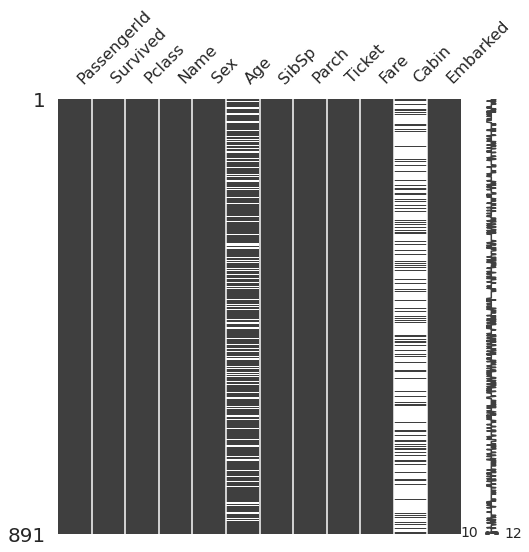

In [8]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8))

<AxesSubplot:>

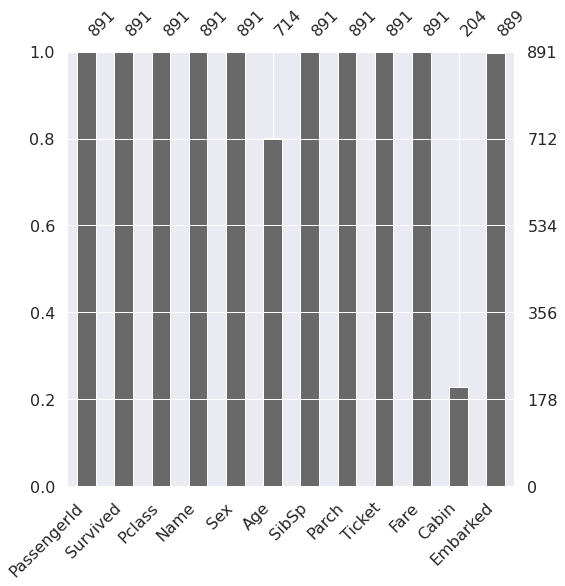

In [9]:
msno.bar(df=df_train.iloc[:,:], figsize=(8,8))

<AxesSubplot:>

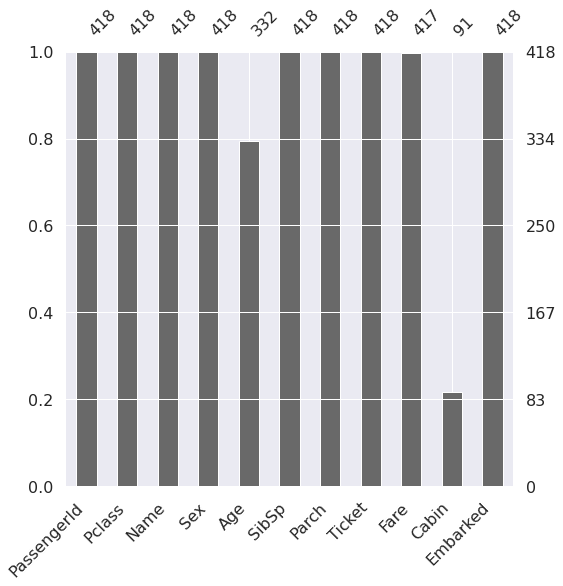

In [10]:
msno.bar(df=df_test.iloc[:,:], figsize=(8,8))

## target label 확인하기
- binary classification 문제의 경우, 1과 0의 분포가 어떠냐에따라 모델의 평가방법이 달라 질 수 있다.

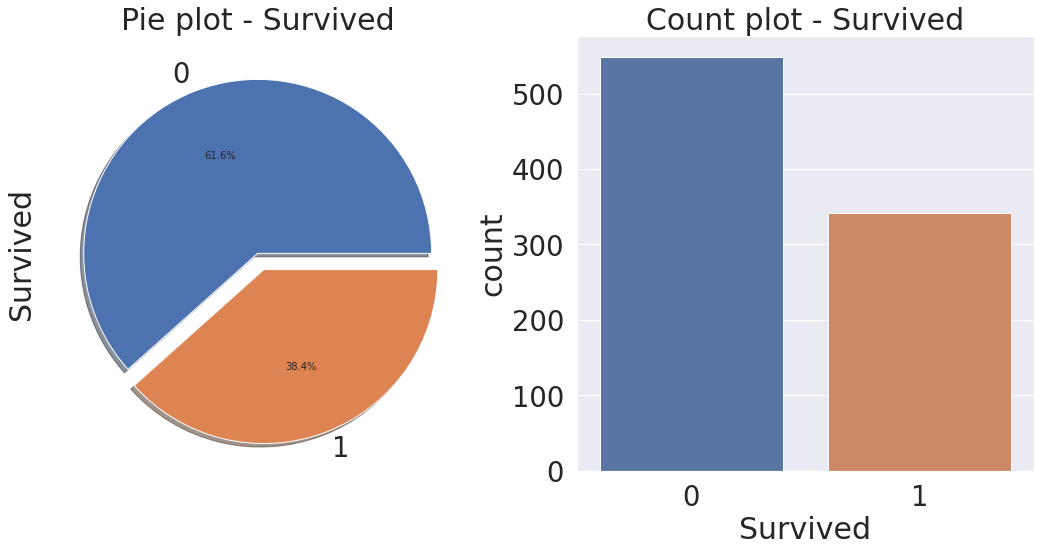

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

- 38.4가 생존
- target label의 분포가 제법 균일

## 데이터 분석
- 시각화를 통해 데이터 분석하기

### Pclass
- ordinal, 서수형 데이터
- 카테고리이면서 순서가있다
- Pclass와 survived의 관계파악

In [12]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [14]:
# Pandas의 crosstab을 사용하면 좀더 수월하게 할 수 있음
pd.crosstab(df_train['Pclass'],df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<AxesSubplot:xlabel='Pclass'>

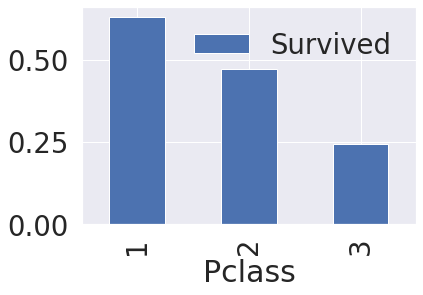

In [15]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

- Pclass가 높을수록 생존률이 높다. 

Text(0.5, 1.0, 'Pclass by Survived')

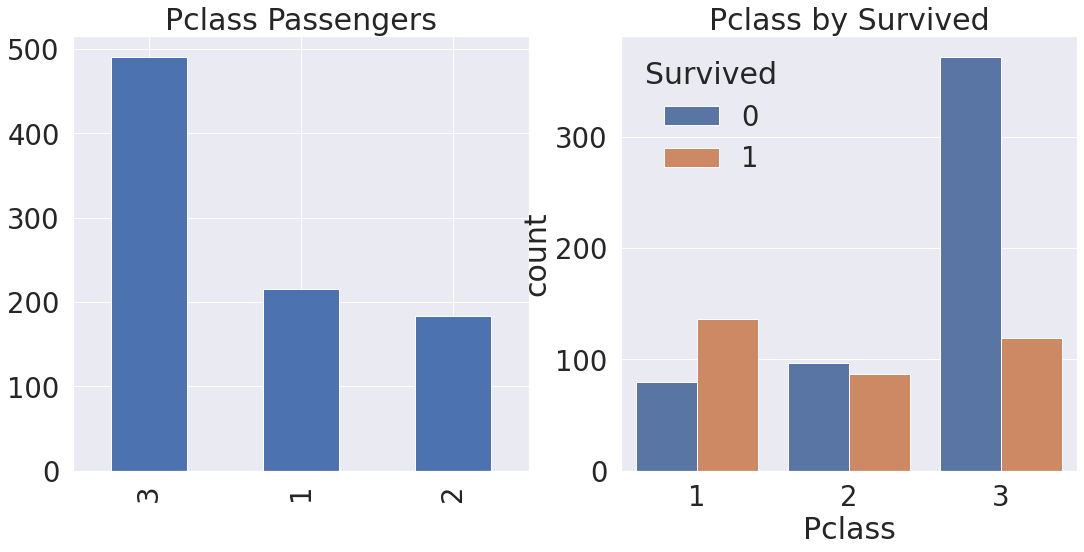

In [16]:
y_position = 1.02
fig, ax = plt.subplots(1,2,figsize = (18,8))
df_train["Pclass"].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Pclass Passengers')
sns.countplot('Pclass',hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('Pclass by Survived')

- 클래스가 높을수록 생존확률이 높다.
- 생존에 Pclass가 영향을 큰 끼치는 것을 볼 수 있다.

### Sex
- 성별과 생존률 분석

Text(0.5, 1.0, 'Survived by Sex')

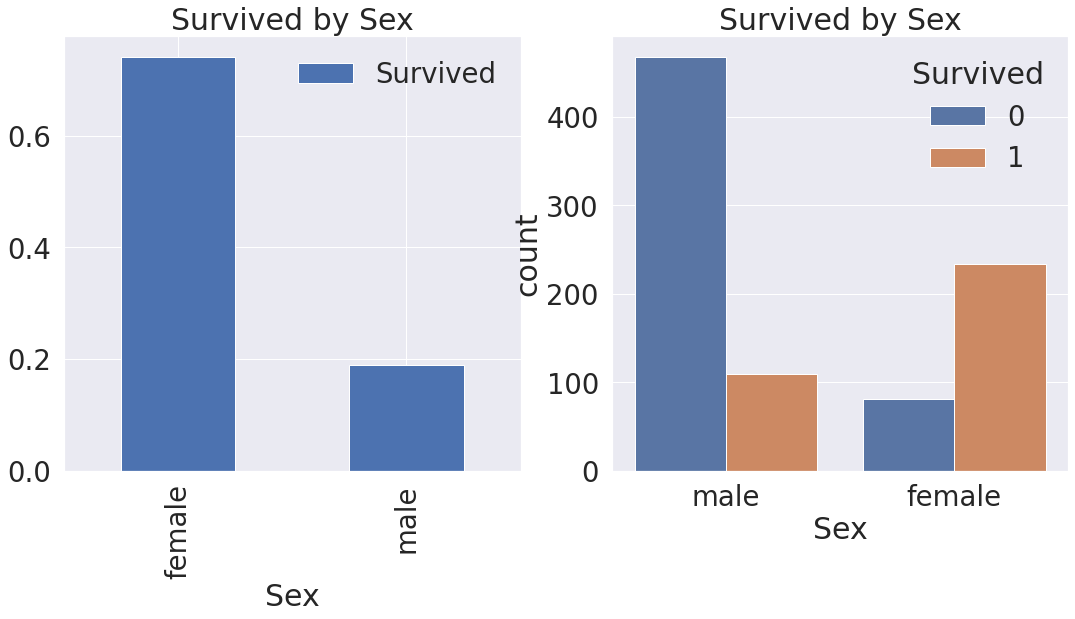

In [17]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
df_train[['Sex','Survived']].groupby(['Sex'], as_index = True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived by Sex')
sns.countplot('Sex',hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('Survived by Sex')

- 여자가 생존할 확률이 높다 

In [18]:
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
pd.crosstab(df_train['Sex'],df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


### Both Sex and Pclass
- Sex와 Pclass에 관하여 생존률 확인하기 

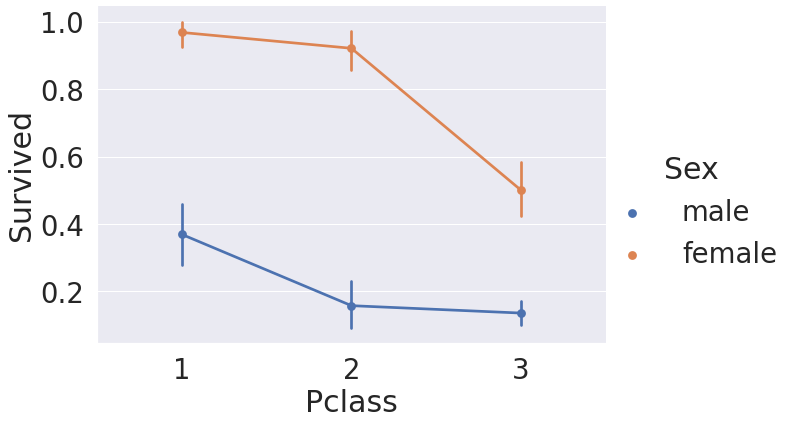

In [20]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect= 1.5)

- 모든 부분에서 여성이 살 확률이 남성보다 높다.

### Age 

In [21]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


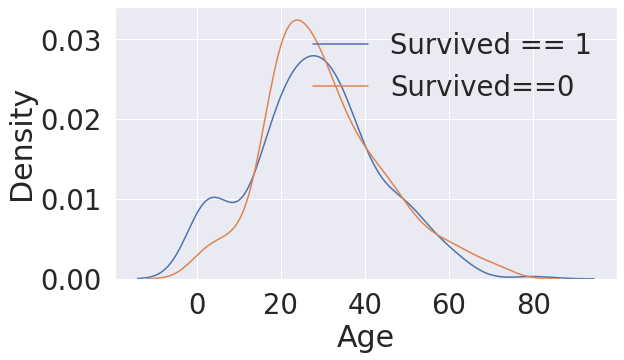

In [22]:
fig, ax = plt.subplots(figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'])
sns.kdeplot(df_train[df_train['Survived']==0]['Age'])
plt.legend(['Survived == 1', 'Survived==0'])

- 생존자들중 나이가 어린경우가 많다

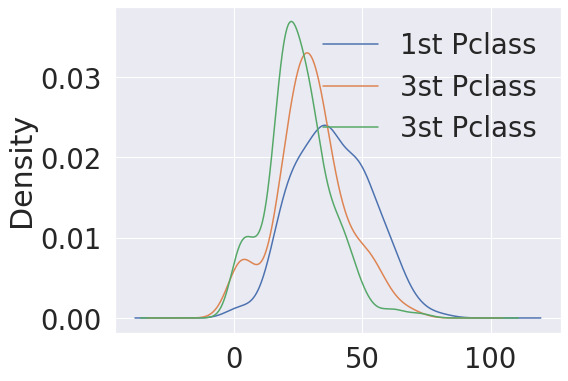

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')
plt.legend(['1st Pclass','3st Pclass','3st Pclass'])

- class가 높을수록 나이많은사람의 비중이 커짐
- 나이대가 변하면서 생존률을 확인하고 싶다

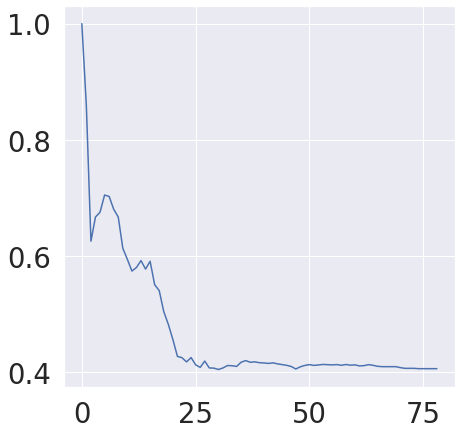

In [24]:
cummulate_survival_ratio = []
for i in range(1,80):
    cummulate_survival_ratio.append(df_train[df_train['Age']<i]['Survived'].sum()/len(df_train[df_train['Age']<i]['Survived']))
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)

- 나이가 어릴수록 생존률이 확실하게 높다
- 이로써 나이가 중요한 feature로 쓰일 수 있다.

### Pclass,Sex,Age 
- 세개의 컬럼에 대해 시각화

<AxesSubplot:xlabel='Sex', ylabel='Age'>

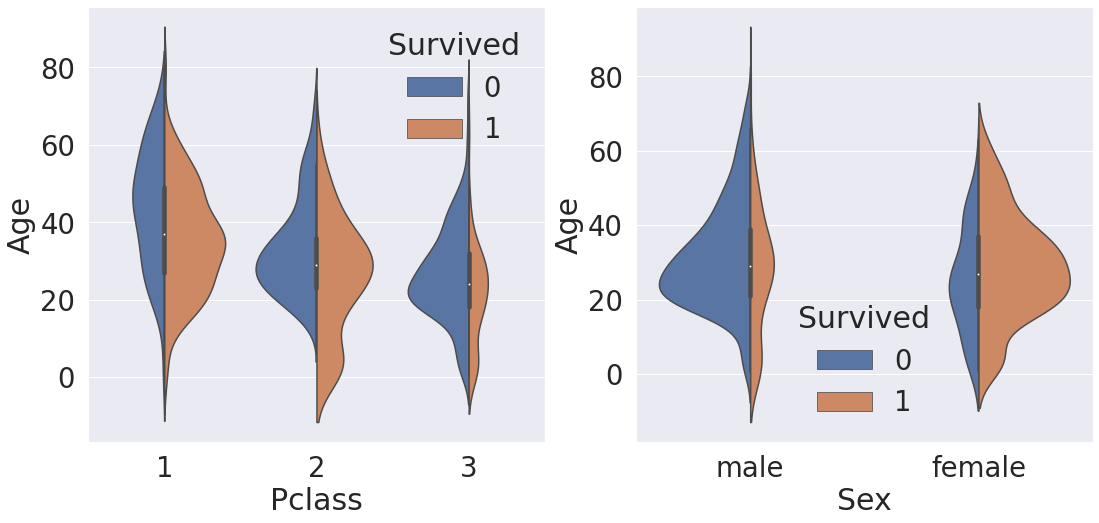

In [25]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.violinplot("Pclass","Age",hue="Survived",data=df_train,scale='count',split=True,ax=ax[0])
sns.violinplot("Sex","Age",hue="Survived",data=df_train,scale='count',split=True,ax=ax[1])

- 왼쪽은 Pclass별 Age의 분산을 나타낸다
- 오른쪽은 Sex별 Age의 분산을 나타낸다.
- 모든 클래스에서 나이가 어릴수록 생존을 많이했고
- 여성이 남성보다 생존을 많이했다.

### Embarked
- 탑승한 항구를 의미
- 탑승한 곳에 따른 생존률을 시각화한다.

<AxesSubplot:xlabel='Embarked'>

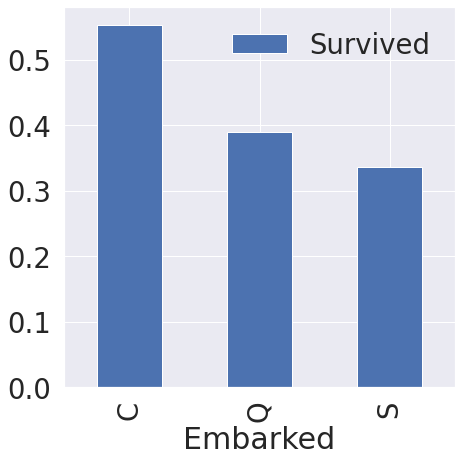

In [26]:
f, ax = plt.subplots(figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

- 생존률은 비슷하지만 C가 제일 높다.
- 모델에 따라서 조금 다르지만 사용

<AxesSubplot:xlabel='Embarked', ylabel='count'>

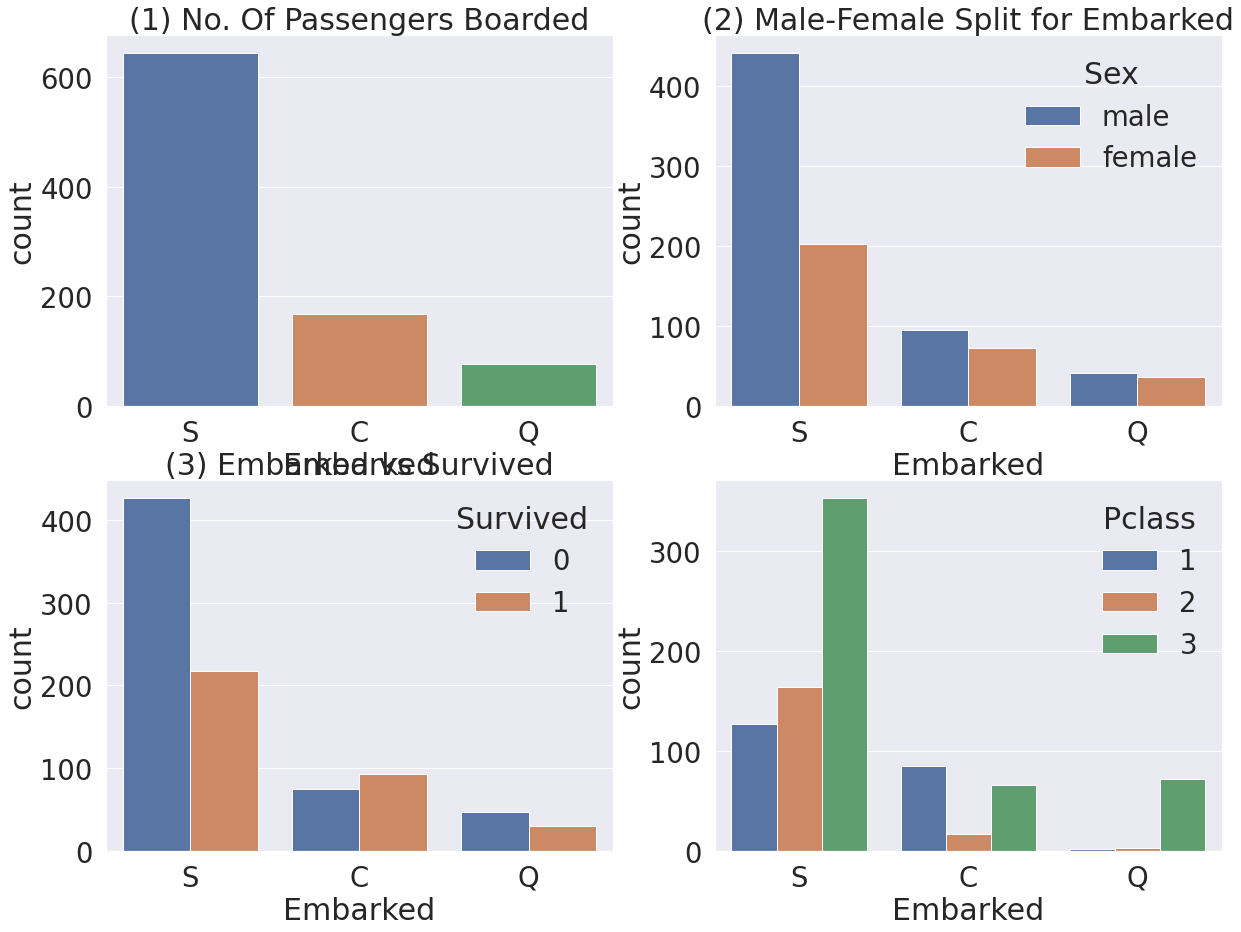

In [27]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=df_train,ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=df_train,ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=df_train,ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=df_train,ax=ax[1,1])

- (1) 전체적으로 S에서 제일 많은 사람이 탑승
- (2) C와 Q는 남녀의 비율이 비슷하고 S는 남자가 두배정도 더많다.
- (3) 생존확률이 S가 많이 낮다.
- (4) Class별로 C가 생존확률이 높다. 하지만 이것은 S에서 사람이 많이타서 그렇다.

### Family-SibSp(형제자매),Parch(부모,자녀)
- Sibsp+Parch=Family 

In [28]:
df_train['FamilySize']=df_train['SibSp']+df_train['Parch']+1 # 자기자신 포함
df_test['FamilySize']=df_test['SibSp']+df_test['Parch']+1 # 자기자신 포함

Text(0.5, 1.02, '(3) Survived rate depending on FamilySize')

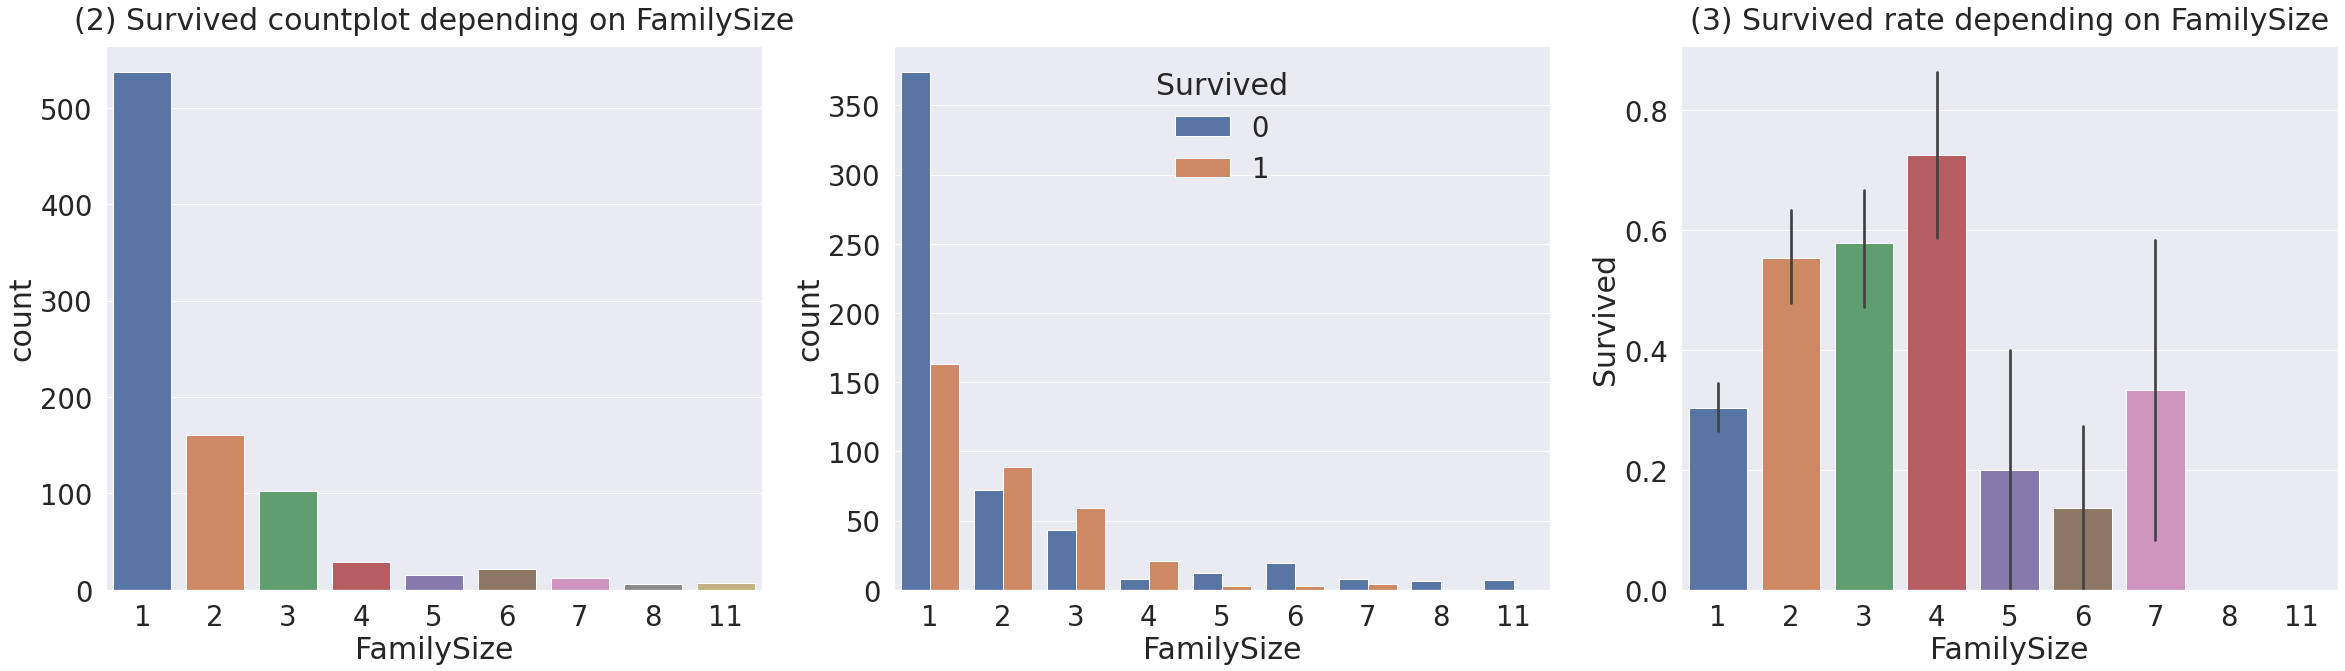

In [29]:
fig, ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot('FamilySize',data=df_train,ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)
sns.countplot('FamilySize',hue='Survived',data=df_train,ax=ax[1])
ax[0].set_title('(2) Survived countplot depending on FamilySize', y=1.02)
sns.barplot('FamilySize','Survived',data=df_train,ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

- (1) 가족의 크기가 1~11까지 있다
- (2),(3) 가족이 4명인경우가 가장 생존확률이 높다
- 가족수가 너무많아도, 커도 생존확률이 작다

### Fare
- 탑승요금을 의미하며 contious feature이다  
- histogram을 사용해서 시각화 

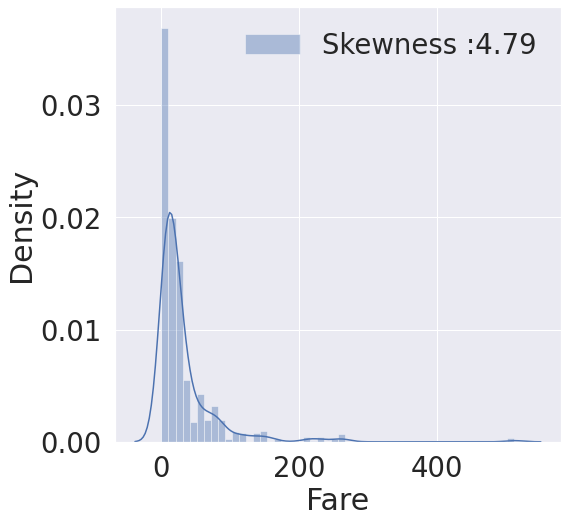

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
g = sns.distplot(df_train['Fare'],color='b',label='Skewness :{:.2f}'.format(df_train['Fare'].skew()))
g = g.legend(loc='best')

- 분산이 매우 비대칭이다. 모델에 넣어주면 모델이 잘못학습할 수 있다.
- outliner의 영향을 줄이기위해 log를 취한다.

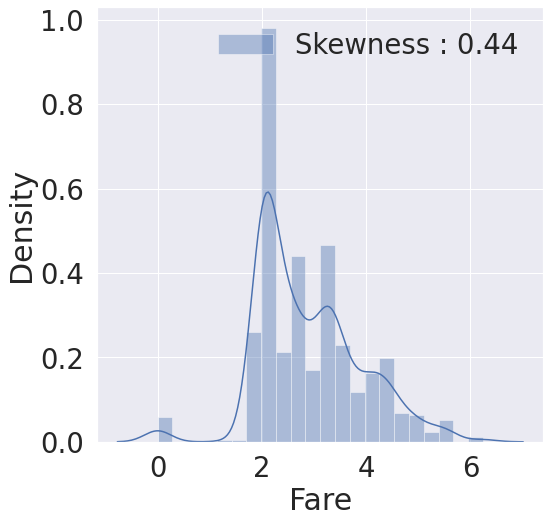

In [31]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() 
# testset 에 있는 nan value 를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- log를 취하니 비대칭성이 많이 사라졌다.
- 이런작업은 데이터전처리에 들어가는데 지금했다.

### Cabin
- NaN이 대략 80%이므로 포함하지않는다

### Ticket
- NaN은 없다.
- 하지만 실제 모델에 사용하려면 아이디어를 통해 작업을 해야한다.

In [32]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- Ticket은 많이 다양하다.

## 데이터 전처리 

### 누락값 채우기
- Age에 누락값 177개가 있다
- Miss, Mrr, Mrs같은 title 존재 

In [33]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
#lets extract the Salutations
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')

- pandas의 crosstab을 사용하여 Initial과 Sex간의 count를 살펴보기

In [34]:
pd.crosstab(df_train['Initial'],df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 남자와 여자가 쓰는 Initital 구분 가능 

In [35]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [36]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss, Mr, Mrs가 생존률이 높다

<AxesSubplot:xlabel='Initial'>

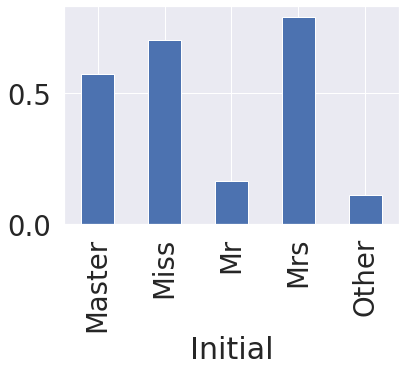

In [37]:
#sns.barplot('Initial','Survived',data=df_train)
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 null을 채울것이다.
- train에서 얻은 값을 기반으로 test의 null data를 채워줘야한다.

In [38]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해서 Null값을 채운다 
- loc + boolean + column은 자주쓴다.

In [39]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### Embarked 값 

In [40]:
print('Embarked has ',sum(df_train['Embarked'].isnull()),' Null values')

Embarked has  2  Null values


- Null value값이 2개가있고 S가 가장많으니 S로 채운다 

In [41]:
df_train['Embarked'].fillna('S',inplace=(True))

### Change Age
- Age는 현재 continuous feather이다.  Age를 몇개의 그룹으로 나눠서 category화 시켜줄수도 있다.

- loc를 사용하는 방법

In [42]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- apply 메소드를 넣어주면 훨씬 수월

In [43]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [44]:
df_train.drop(['Age','Age_cat_2'],axis=1,inplace=True)
df_test.drop(['Age'],axis=1,inplace=True)

### Intial,Embarked,Sex 바꾸기 
- Intial은 Mr,Mrs,Miss,Master,Other로 구성되어있는데 카테고리로 표현해줄때 수치화시켜줘야한다.
- map 매써드를 사용하여 간단히 할 수 있다.

In [45]:
df_train['Initial'] = df_train['Initial'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Other':4})

- Embarked도 C, Q, S로 이루어져있다.

In [46]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0,'Q':1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0,'Q':1,'S':2})

- null값 확인

In [47]:
df_train['Embarked'].isnull().any()

False

- Sex도 바꿔준다.

In [48]:
df_train['Sex'] = df_train['Sex'].map({'female':0,'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0,'male':1})

### heatmap을 그려 상관관계를 알아보자

<AxesSubplot:>

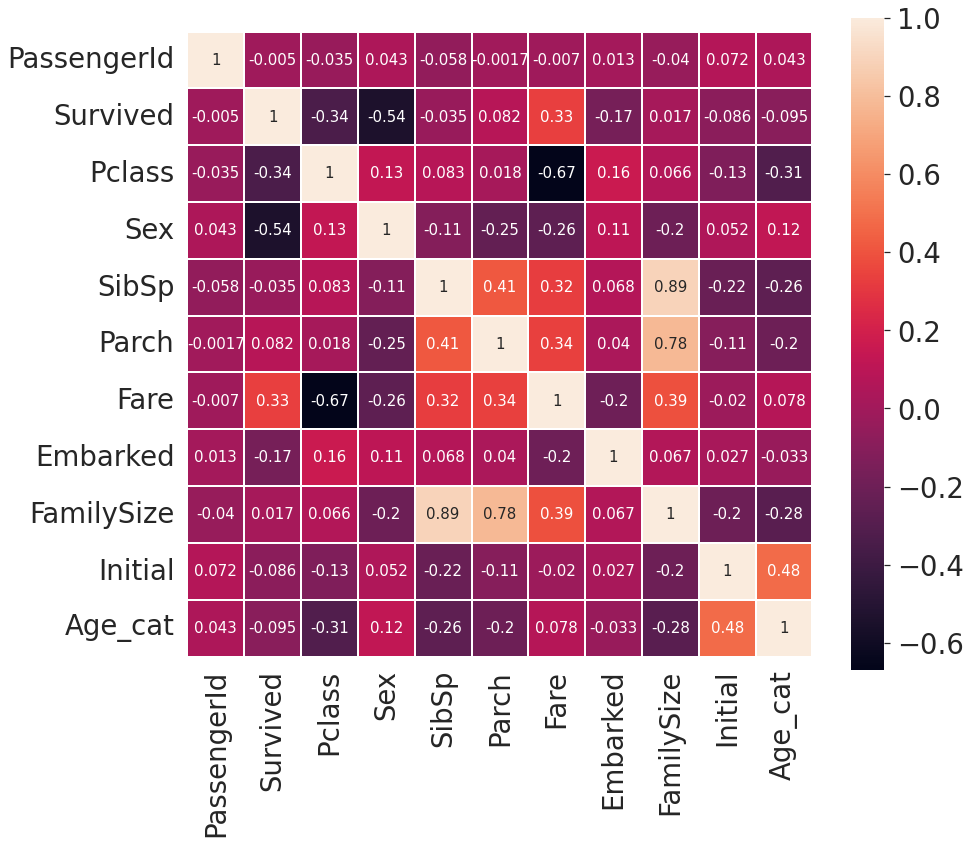

In [49]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True,annot_kws={"size":15})

- Sex와 Pclass가 Suvived에 상관관계가 어느정도 있다
- fare와 Embarked도 상관관계가 좀 있다.
- 서로강한 상관관계를 가진 feather들이 없어서 불필요한 feather가 없다. 

### 원핫 인코딩 

- 수치화시킨 카테고리를 그대로 넣어도 되지만, 모델의 성능을 높히기위해 원핫인코딩 실행
- 0,1로 이루어진 5차원으 벡터로 구성 
- 카테고리 수 만큼 새로운 컬럼이 생김

In [50]:
df_train = pd.get_dummies(df_train, columns=["Initial"],prefix='Initial')
df_test = pd.get_dummies(df_test, columns=["Initial"],prefix='Initial')

In [51]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- Embarked에도 적용한다

In [52]:
df_train = pd.get_dummies(df_train, columns=['Embarked'],prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'],prefix='Embarked')

### Drop columns

In [53]:
df_train.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis = 1,inplace=True)
df_test.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis = 1,inplace=True)

In [54]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [55]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 머신러닝

In [56]:
X_train = df_train.drop('Survived',axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 좋은 모델을 만들기 위해 valid set을 따로 만든다

In [57]:
X_tr, X_vld,y_tr,y_vld = train_test_split(X_train,target_label,test_size = 0.3,random_state=2018)

In [58]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.09% 정확도로 생존을 맞춤


- 학습된 모델은 feather importance를 가지는데 이것을 확인하여 모델이 어떤 feather에 영향을 많이 받았는 지 확인 할 수 있다.

In [59]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance,index=df_test.columns)

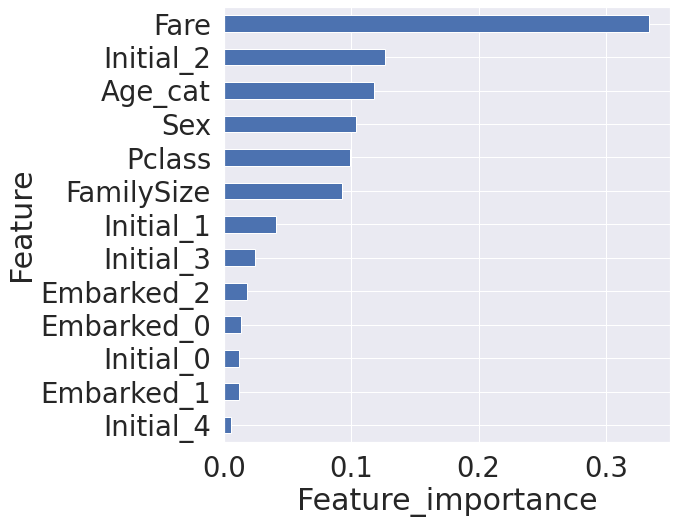

In [60]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature_importance')
plt.ylabel('Feature')
plt.show()

- Fare가 가장 큰 영향력을 가지며 Age_cat, Initial_2,Pclass가 차례로 중요도를 가진다.

### 실제 테스트
- 테스트셋을 모델에 주어서 생존여부를 예측

In [61]:
submission = pd.read_csv(DATA_PATH + 'gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [62]:
pred = model.predict(X_test)
submission['Survived'] = pred
submission.to_csv('./submission.csv', index=False)